# Tarea Principal
- Se pide implementar el método propuesto por Cardoso y Sousa en su artículo "Measuring the Performance of Ordinal Classification".

## Problema
- Se describe, de forma sencilla, el problema de clasificación ordinal como aquel en el que el orden de las clases importa a la hora de realizar predicciones. 
- Los costos no son los mismos que en un aprendizaje normal, pues ser un error más severo clasificar una instancia $x$ como $C_1$ cuando en realidad su clase era $C_4$, que clasificarla erróneamente como $C_3$, todo esto teniendo en cuenta un orden hipotético como $C_1>C_2>C_3>C_4$.

## Solución de Replicación de Datos por Cardoso y Sousa
- Se explica el caso lineal, que es el que se va a tratar.
- Dadas $k$ clases ordinales con un orden $C_1>C_2>...>C_k$, el objetivo es encontrar límites de decisión (hiperplanos) paralelos que respeten este orden.
- Se explica en el artículo de referencia que, cada hiperplano de indice $i$ separada las clases menores o igual a $C_i$ de las clases mayores o igual a $C_{i+1}$ De esta forma, existe un parámetro $s$ que indica cuantas clases influyen en la construcción del hiperplano $i$, en el que se consideran $s$ clases a la izqueirda y $s$ clases a la derecha. En los extremos, sin embargo, puede haber menos de $s$ clases.
- Se propone replicar cada punto en un espacio aumentado, normalmente se replica $k-1$ vees en un espacio extendido $\mathbb{R}^{p+k-2}$ para un espacio original $\mathbb{R}^p$.
- Dado este nuevo espacio se entrena un clasificador binario, de forma que el hiperplano obtenido es paralelo a los hiperplanos correspondientes al espacio original. Para mapear el hiperplano obtenido de forma $W^TX+b=0$, con pesos y vectores en el espacio aumentado, se realiza la siguiente transformación a cada hiperplano ($k-1$ concretamente) en el espacio original:
$$b_i = \begin{cases} 
b & \text{if } i = 1, \\
h w_{p_{i-1}} + b & \text{if } i > 1.
\end{cases}
$$

# Implementación en Python

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator

class DataReplicationOrdinalClassifier(BaseEstimator):
    def __init__(self, model=LinearSVC(), h=1.0, s=None):
        self.h = h
        self.model = model
        self.K = None
        self.classes_ = None
        self.s = s

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.K = len(self.classes_)
        if self.s is None:
            self.s = self.K - 1  # Default to maximum s if not provided
        if self.s < 1 or self.s > self.K - 1:
            raise ValueError("s must be between 1 and K-1")
        if not np.array_equal(self.classes_, np.arange(1, self.K + 1)):
            raise ValueError("Classes must be integers 1 to K")

        X_ext, y_ext = [], []

        for xi, yi in zip(X, y):
            for q in range(self.K - 1):  # K-1 new points
                eq = np.zeros(self.K - 2)
                if q != 0:
                    eq[q - 1] = self.h
                x_new = np.concatenate([xi, eq])

                # Calculate ranges based on current boundary
                i = q + 1
                left_lower = max(i - self.s + 1, 1)
                left_upper = i
                right_lower = i + 1
                right_upper = min(i + self.s, self.K)

                # Assign label
                if left_lower <= yi <= left_upper:
                    label = 0  # Class Ḡ₁
                elif right_lower <= yi <= right_upper:
                    label = 1  # Class Ḡ₂
                else:
                    continue  # Skip if not in either range

                X_ext.append(x_new)
                y_ext.append(label)

        self.model.fit(X_ext, y_ext)

    def predict(self, X):
        preds = []
        for xi in X:
            votes = 0
            for q in range(self.K - 1):  # K-1 new points
                eq = np.zeros(self.K - 2)
                if q != 0:
                    eq[q - 1] = self.h
                x_new = np.concatenate([xi, eq])
                pred = self.model.predict([x_new])[0]
                votes += pred
            preds.append(votes + 1)  # Sum votes and add 1 for class
        return np.array(preds)

## Explicación del código
- Se ha seguido la interfaz convencional de los modelos predictivos de *scikit-learn* por comodidad.
- Se replican $k-1$ veces cada dato/observación, siendo $k$ el número de clases. Cada réplica añade $k-2$ características nuevas, de forma que una de ellas es la constante $h>0$. Esta constante controla la separación entre los hiperplanos paralelos, si se omitiese todos estos colapsarían en uno solo ya que serían idénticos.
- Se calculan las nuevas etiquetas binarias basándonos en las formas que delimitan el nuevo espacio aumentado. De esta forma se separan por grupos (gracias al parámetro $s$).

$$\left[ x_k^{(i)} \right] \in \begin{cases}
\bar{C}_1 & k = 1, \\
\bar{C}_2 & k = 2, \ldots, \min(K, 1+s),
\end{cases}$$

$$\left[ x_k^{(i)} \right] \in \begin{cases}
\bar{C}_1 & k = \max(1, q-s+1), \ldots, q, \\
\bar{C}_2 & k = q+1, \ldots, \min(K, q+s),
\end{cases}$$


$$\left[ x_k^{(i)} \right] \in \begin{cases}
\bar{C}_1 & k = \max(1, K-1-s+1), \ldots, K-1, \\
\bar{C}_2 & k = K,
\end{cases}$$

- Se omiten aquellos puntos que no entren en el rango de comparación.
- Para el método *predict* se vuelve a expandir la dimensión de los puntos con $k-1$ réplicas y $k-2$ nuevas dimensiones.
- A la hora de predecir, como los límites entre clases son paralelos y ordenados y el truco de replicación fuerza a que los "cortes" entre clases sigan el orden establecido, entonces, asumiendo que los límites son ordenados, eso fuerza a que la clasificación por cada punto y su réplica también debe ser ordenada.
- Se calcula la clase predicha como el número de clases positivas predichas $+ 1$.


# Resultados

In [145]:
from scipy.io import arff
import polars as pl

swd = arff.loadarff("data/swd.arff")
era = arff.loadarff("data/era.arff")
esl = arff.loadarff("data/esl.arff")
lev = arff.loadarff("data/lev.arff")
datasets = {"swd": swd, "era": era, "esl": esl, "lev": lev}

results = pl.DataFrame()

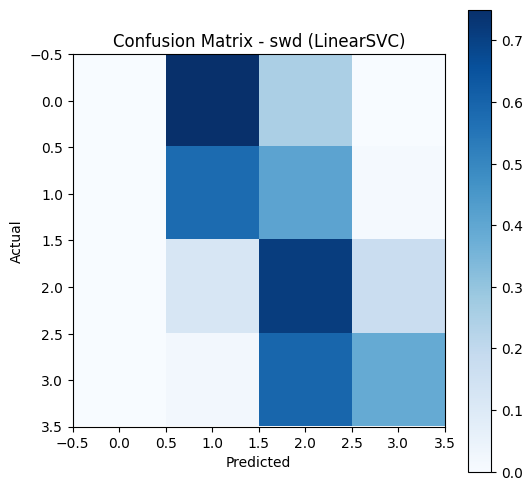

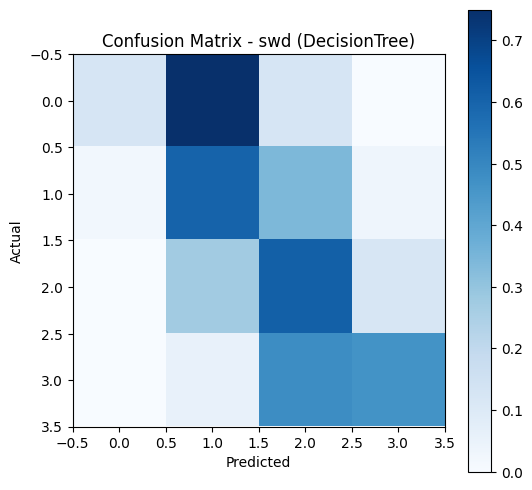

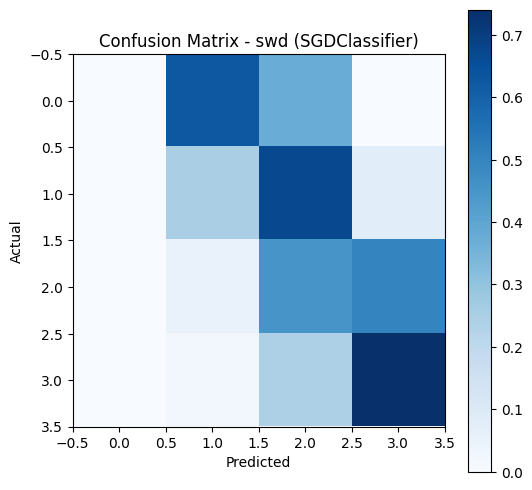

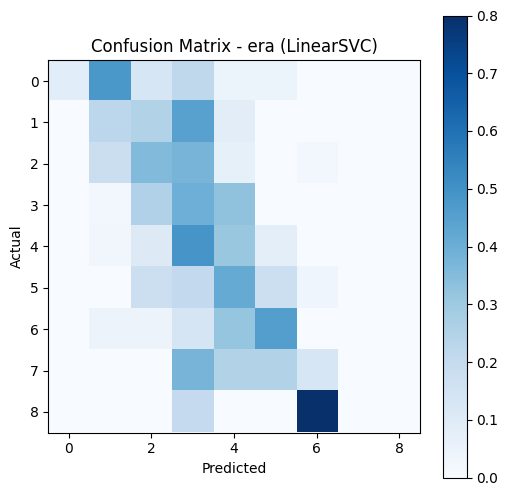

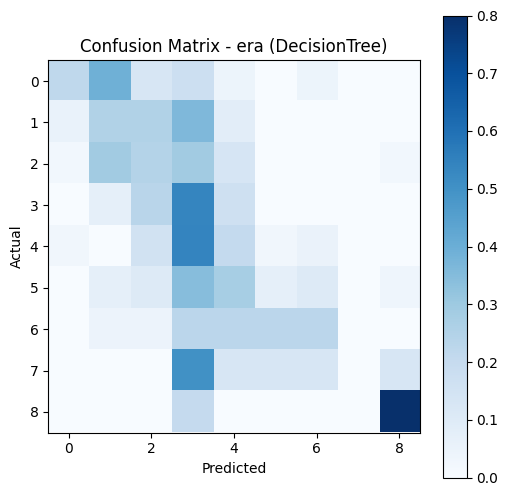

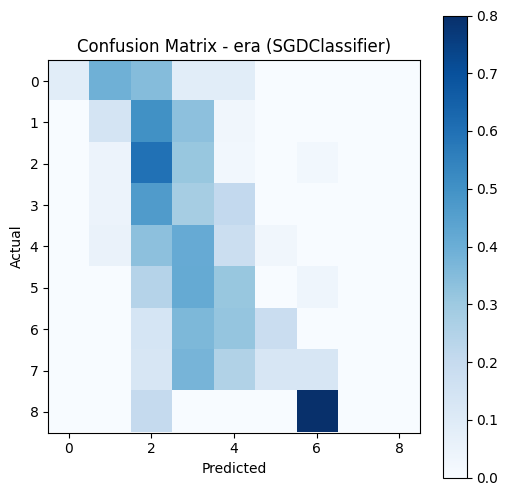

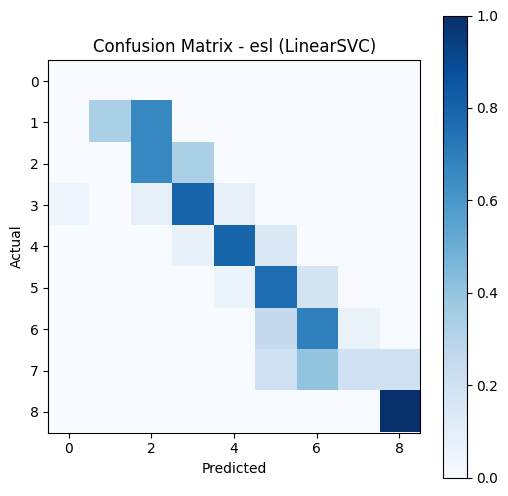

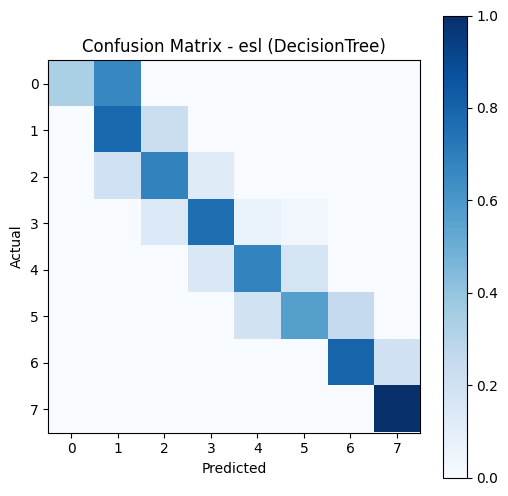

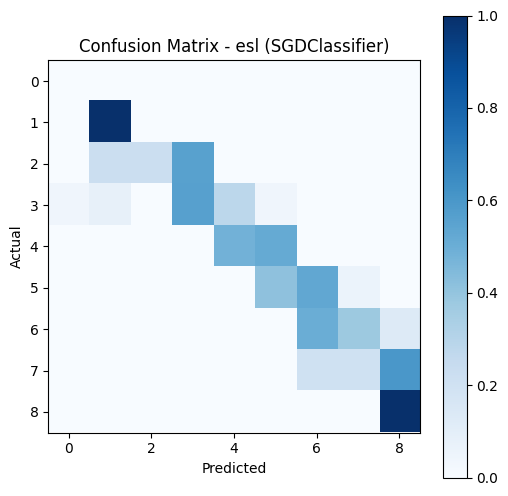

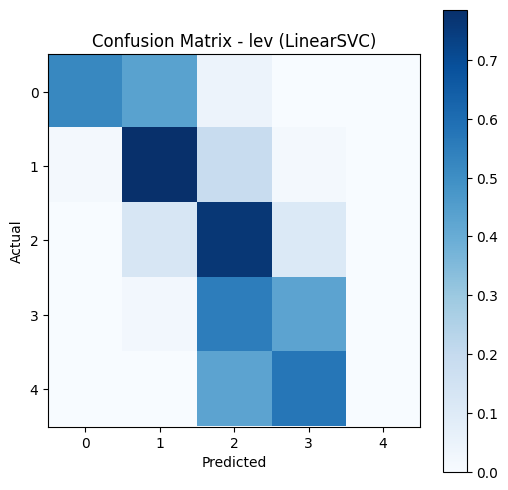

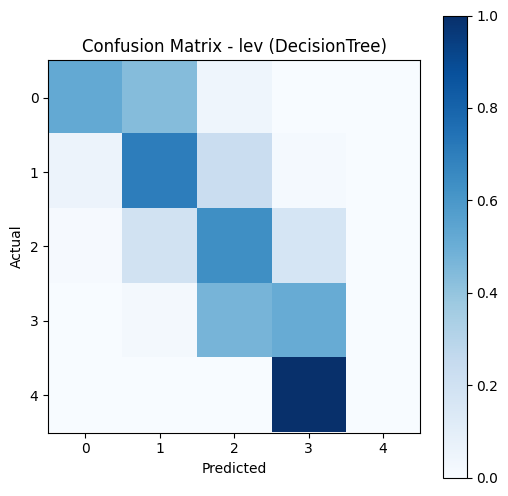

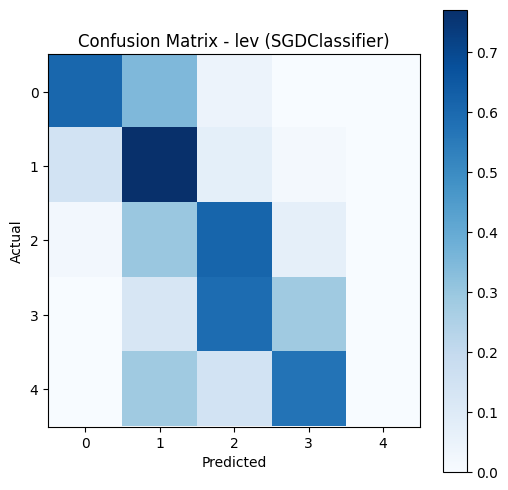

Model Performance Results:
shape: (12, 4)
┌───────────────┬──────────┬──────────┬─────────┐
│ model         ┆ accuracy ┆ mae      ┆ dataset │
│ ---           ┆ ---      ┆ ---      ┆ ---     │
│ str           ┆ f64      ┆ f64      ┆ str     │
╞═══════════════╪══════════╪══════════╪═════════╡
│ LinearSVC     ┆ 0.572    ┆ 0.444    ┆ swd     │
│ DecisionTree  ┆ 0.56     ┆ 0.468    ┆ swd     │
│ SGDClassifier ┆ 0.428    ┆ 0.616    ┆ swd     │
│ LinearSVC     ┆ 0.24     ┆ 1.216    ┆ era     │
│ DecisionTree  ┆ 0.268    ┆ 1.248    ┆ era     │
│ …             ┆ …        ┆ …        ┆ …       │
│ DecisionTree  ┆ 0.688525 ┆ 0.319672 ┆ esl     │
│ SGDClassifier ┆ 0.467213 ┆ 0.606557 ┆ esl     │
│ LinearSVC     ┆ 0.66     ┆ 0.364    ┆ lev     │
│ DecisionTree  ┆ 0.6      ┆ 0.416    ┆ lev     │
│ SGDClassifier ┆ 0.576    ┆ 0.484    ┆ lev     │
└───────────────┴──────────┴──────────┴─────────┘

Performance Summary:
shape: (3, 5)
┌───────────────┬───────────────┬──────────────┬──────────┬──────────┐
│

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

results = pl.DataFrame(
    {
        "model": pl.Series([], dtype=pl.Utf8),
        "accuracy": pl.Series([], dtype=pl.Float64),
        "mae": pl.Series([], dtype=pl.Float64),
        "dataset": pl.Series([], dtype=pl.Utf8),
    }
)

for name, data in datasets.items():
    df = pl.DataFrame(data[0])
    df = df.rename({col: col.lower() for col in df.columns})

    y = df["out1"]
    X = df.select(pl.all().exclude("out1"))
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    # Convert classes to ordinal numbers (1 to K)
    unique_classes = np.unique(y_np)

    class_mapping = {cls: i + 1 for i, cls in enumerate(sorted(unique_classes))}
    y_ordinal = np.vectorize(class_mapping.get)(y_np)

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_np, y_ordinal, test_size=0.2, random_state=42, stratify=y_ordinal
    )

    # Define common model training function
    def train_and_evaluate(model, model_name):
        clf = DataReplicationOrdinalClassifier(model=model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        cm = confusion_matrix(y_test, y_pred, normalize="true")
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {name} ({model_name})")
        plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        plt.close()

        return pl.DataFrame(
            {
                "model": [model_name],
                "accuracy": [accuracy],
                "mae": [mae],
                "dataset": [name],
            }
        )

    models = [
        ("LinearSVC", LinearSVC(random_state=42)),
        ("DecisionTree", DecisionTreeClassifier(random_state=42)),
        ("SGDClassifier", SGDClassifier(random_state=42)),
    ]

    for model_name, model in models:
        new_results = train_and_evaluate(model, model_name)
        results = results.vstack(new_results)

print("Model Performance Results:")
print(results)

summary = results.group_by("model").agg(
    pl.col("accuracy").mean().alias("mean_accuracy"),
    pl.col("accuracy").std().alias("std_accuracy"),
    pl.col("mae").mean().alias("mean_mae"),
    pl.col("mae").std().alias("std_mae"),
)

print("\nPerformance Summary:")
print(summary)

best_models = results.filter(
    pl.col("accuracy") == pl.col("accuracy").max().over("dataset")
).select(["dataset", "model", "accuracy"])

print("\nBest Models by Dataset:")
print(best_models)

# Análisis de resultados
- El método utilizando *LinearSVC* emerge como el mejor clasificador en general:
    - Mayor accuracy promedio ($0.550$) y menor MAE promedio ($0.580$)
    - Domina en $3/4$ datasets (swd, esl, lev)
- En el *dataset* era hay una claro problema a la hora de discernir clases (quizá por un desbalance extremo), aunque *LinearSVC* consigue balancear mejor los otros algoritmos de clasificación.
- En el *dataset* esl y lev se consiguen resultados muy buenos, las fronteras paralelas parecen ser una suposición válida en estos problemas.

## Posibles limitaciones
- La complejidad computacional del método es muy elevada. Con cada instancia se aumenta la complejidad del conjunto de datos en $k-2$ dimensiones. Esto es, además de un problema por el tiempo de entrenamiento y por la memoria necesitada, un problema por la maldición de la dimensionalidad, de forma que los puntos en el espacio pueden alcanzar distancias muy elevadas, lo que conllevaría a una necesidad de mayor cantidad de datos.
- Es sensible a parámetros como $h$ o $s$, debe realizarse una selección de estos parámetros.
- Solo se ha implementado la versión lineal, por lo que no conozco problemáticas en topologías más complejas, pero las restricciones sin duda se complicarían.